# Superposition by embedding bottleneck

This is an experiment to squash higher-dimensional data into a lower-dimensional embedding space. We'll start with color: RGB values (3 dimensions) ranging from 0..1. If we compress them into a 2D embedding, we should expect to see superposition, with directions interpretable as they would be in a classic color wheel: three primary color directions (RGB) spaced 120° apart.


In [1]:
from __future__ import annotations

In [2]:
import logging
from utils.logging import SimpleLoggingConfig

logging_config = SimpleLoggingConfig().info('notebook', 'utils', 'mini', 'ex_color')
logging_config.apply()

# This is the logger for this notebook
log = logging.getLogger('notebook')

## Simple MLP with bottleneck

We'll train a simple 2-layer MLP with low-dimensional bottleneck to map RGB values (inputs like [1.0, 0.0, 0.0] for red) to RGB values. This would force colors into an embedding space where we expect to see the superposition effect.

In [3]:
import torch
import torch.nn as nn


class ColorMLP(nn.Module):
    def __init__(self, normalize_bottleneck=False):
        super().__init__()
        # RGB input (3D) → hidden layer → bottleneck → hidden layer → RGB output
        self.encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            # nn.Linear(16, 16),
            # nn.GELU(),
            nn.Linear(16, 3),  # Our critical bottleneck!
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            # nn.Linear(16, 16),
            # nn.GELU(),
            nn.Linear(16, 3),
            nn.Sigmoid(),  # Keep RGB values in [0,1]
        )

        self.normalize = normalize_bottleneck

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Get our bottleneck representation
        bottleneck = self.encoder(x)

        # Optionally normalize to unit vectors (like nGPT)
        if self.normalize:
            norm = torch.norm(bottleneck, dim=1, keepdim=True)
            bottleneck = bottleneck / (norm + 1e-8)  # Avoid division by zero

        # Decode back to RGB
        output = self.decoder(bottleneck)
        return output, bottleneck

## Training machinery

In [ ]:
from dataclasses import dataclass
from typing import Protocol, runtime_checkable
from torch import Tensor
import torch.optim as optim

from mini.temporal.timeline import State


@dataclass
class InferenceResult:
    outputs: Tensor
    latents: Tensor

    def detach(self):
        return InferenceResult(self.outputs.detach(), self.latents.detach())

    def clone(self):
        return InferenceResult(self.outputs.clone(), self.latents.clone())

    def cpu(self):
        return InferenceResult(self.outputs.cpu(), self.latents.cpu())


@runtime_checkable
class LossCriterion(Protocol):
    def __call__(self, data: Tensor, res: InferenceResult) -> Tensor: ...


@runtime_checkable
class SpecialLossCriterion(LossCriterion, Protocol):
    def forward(self, model: ColorMLP, data: Tensor) -> InferenceResult | None: ...


@dataclass(eq=False, frozen=True)
class Event:
    name: str
    step: int
    model: ColorMLP
    timeline_state: State
    phase_dataset: Tensor
    datasets: dict[str, Tensor]
    optimizer: optim.Optimizer


@dataclass(eq=False, frozen=True)
class PhaseEndEvent(Event):
    inference_result: InferenceResult


class EventHandler[T](Protocol):
    def __call__(self, event: T) -> None: ...


class EventBinding[T]:
    """A class to bind events to handlers."""

    def __init__(self, event_name: str):
        self.event_name = event_name
        self.handlers: list[tuple[str, EventHandler[T]]] = []

    def add_handler(self, event_name: str, handler: EventHandler[T]) -> None:
        self.handlers.append((event_name, handler))

    def emit(self, event_name: str, event: T) -> None:
        for name, handler in self.handlers:
            if name == event_name:
                handler(event)


class EventHandlers:
    """A simple event system to allow for custom callbacks."""

    phase_start: EventBinding[Event]
    action: EventBinding[Event]
    phase_end: EventBinding[PhaseEndEvent]

    def __init__(self):
        self.phase_start = EventBinding[Event]('phase_start')
        self.action = EventBinding[Event]('action')
        self.phase_end = EventBinding[PhaseEndEvent]('phase_end')

In [5]:
from torch import Tensor
import torch.optim as optim
from tqdm.auto import tqdm

from mini.temporal.dopesheet import Dopesheet
from mini.temporal.timeline import Timeline


def train_color_model(  # noqa: C901
    model: ColorMLP,
    datasets: dict[str, Tensor],
    dopesheet: Dopesheet,
    loss_criteria: dict[str, LossCriterion | SpecialLossCriterion],
    event_handlers: EventHandlers | None = None,
):
    if event_handlers is None:
        event_handlers = EventHandlers()

    # --- Validate inputs ---
    # Check if all phases in dopesheet have corresponding data
    dopesheet_phases = dopesheet.phases
    missing_data = dopesheet_phases - set(datasets.keys())
    if missing_data:
        raise ValueError(f'Missing data for dopesheet phases: {missing_data}')

    # Check if 'lr' is defined in the dopesheet properties
    if 'lr' not in dopesheet.props:
        raise ValueError("Dopesheet must define the 'lr' property column.")
    # --- End Validation ---

    timeline = Timeline(dopesheet)
    optimizer = optim.Adam(model.parameters(), lr=0)
    device = next(model.parameters()).device

    total_steps = len(timeline)

    with tqdm(total=total_steps, desc='Training Steps') as pbar:
        for step in range(total_steps):
            # Get state *before* advancing timeline for this step's processing
            current_state = timeline.state
            current_phase_name = current_state.phase
            current_data = datasets[current_phase_name]

            # --- Event Handling ---
            event_template = {
                'step': step,
                'model': model,
                'timeline_state': current_state,
                'phase_dataset': current_data,
                'datasets': datasets,
                'optimizer': optimizer,
            }

            if current_state.is_phase_start:
                event = Event(name=f'phase-start:{current_phase_name}', **event_template)
                event_handlers.phase_start.emit(event.name, event)
                event_handlers.phase_start.emit('phase-start', event)

            for action in current_state.actions:
                event = Event(name=f'action:{action}', **event_template)
                event_handlers.action.emit(event.name, event)
                event_handlers.action.emit('action', event)

            # --- Training Step ---
            # ... (get data, update LR, zero grad, forward pass, calculate loss, backward, step) ...
            current_data = datasets[current_phase_name]

            current_lr = current_state.props['lr']
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

            optimizer.zero_grad()
            outputs, latents = model(current_data)
            current_results = InferenceResult(outputs, latents)

            total_loss = torch.tensor(0.0, device=device)
            losses_dict: dict[str, float] = {}
            for name, criterion in loss_criteria.items():
                weight = current_state.props.get(name, 0.0)
                if weight == 0:
                    continue

                if isinstance(criterion, SpecialLossCriterion):
                    special_results = criterion.forward(model, current_data)
                    if special_results is None:
                        continue
                    term_loss = criterion(current_data, special_results)
                else:
                    term_loss = criterion(current_data, current_results)
                total_loss += term_loss * weight
                losses_dict[name] = term_loss.item()

            if total_loss > 0:
                total_loss.backward()
                optimizer.step()
            # --- End Training Step ---

            # --- Post-Step Event Handling ---
            if current_state.is_phase_end:
                # Trigger phase-end for the *current* phase
                with torch.no_grad():
                    val_outputs, val_latents = model(current_data)
                event = PhaseEndEvent(
                    name=f'phase-end:{current_phase_name}',
                    **event_template,
                    inference_result=InferenceResult(val_outputs, val_latents),
                )
                event_handlers.phase_end.emit(event.name, event)
                event_handlers.phase_end.emit('phase-end', event)
            # --- End Event Handling ---

            # Update progress bar
            pbar.set_postfix(
                {
                    'PHASE': current_phase_name,
                    'lr': f'{current_lr:.6f}',
                    'loss': f'{total_loss.item():.4f}',
                    **{name: f'{lt:.4f}' for name, lt in losses_dict.items()},
                },
            )
            pbar.update(1)

            # Advance timeline *after* processing the current step
            if step < total_steps:  # Avoid stepping past the end
                timeline.step()

    log.info('Training finished!')

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from torch import Tensor


class PhasePlotter:
    """Event handler to plot latent space at the end of each phase."""

    def __init__(self, dim_pairs: list[tuple[int, int]] | None = None):
        from utils.nb import displayer

        # Store (phase_name, end_step, data, result) - data comes from event now
        self.history: list[tuple[str, int, Tensor, InferenceResult]] = []
        self.display = displayer()
        self.dim_pairs = dim_pairs or [(0, 1), (0, 2)]

    # Expect PhaseEndEvent specifically
    def __call__(self, event: PhaseEndEvent):
        """Handle phase-end events."""
        if not isinstance(event, PhaseEndEvent):
            raise TypeError(f'Expected PhaseEndEvent, got {type(event)}')

        # TODO: Don't assume device = CPU
        # TODO: Split this class so that the event handler is separate from the plotting, and so the plotting can happen locally with @run.hither
        phase_name = event.timeline_state.phase
        end_step = event.step
        phase_dataset = event.phase_dataset
        inference_result = event.inference_result

        log.info(f'Plotting end of phase: {phase_name} at step {end_step} using provided results.')

        # Append to history
        self.history.append((phase_name, end_step, phase_dataset, inference_result))

        # Plotting logic remains the same as it already expected CPU tensors
        fig = self._plot_phase_history()
        self.display(fig)
        plt.close(fig)

    def _plot_phase_history(self):
        num_phases = len(self.history)
        if num_phases == 0:
            fig, ax = plt.subplots()
            ax.text(0.5, 0.5, 'Waiting...', ha='center', va='center')
            return fig

        fig, axes = plt.subplots(
            num_phases, len(self.dim_pairs), figsize=(5 * len(self.dim_pairs), 5 * num_phases), squeeze=False
        )

        for row_idx, (phase_name, end_step, data, res) in enumerate(self.history):
            _latents = res.latents.numpy()
            _colors = data.numpy()

            for col_idx, (dim1, dim2) in enumerate(self.dim_pairs):
                ax = axes[row_idx, col_idx]
                ax.scatter(_latents[:, dim1], _latents[:, dim2], c=_colors, s=10, alpha=1)
                if col_idx == 0:
                    ax.set_ylabel(
                        f'Phase: {phase_name}\n(End Step: {end_step})',
                        fontsize='medium',
                        rotation=0,
                        labelpad=40,
                        verticalalignment='center',
                    )
                if row_idx == 0:
                    ax.set_title(f'Dims {dim1} vs {dim2}')
                ax.set_xlabel(f'Dim {dim1}')
                if col_idx != 0:
                    ax.set_ylabel(f'Dim {dim2}')
                else:
                    ax.yaxis.set_label_coords(-0.2, 0.5)
                    ax.set_yticks([])
                ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
                ax.add_patch(Circle((0, 0), 1, fill=False, linestyle='--', color='gray', alpha=0.3))
                ax.set_aspect('equal')

        fig.tight_layout()
        return fig

## Curriculum

In order to get a somewhat predictable orientation in latent space, we'll use curriculum learning:

| Phase | Training Data              | Regularization                       |
| ----- | -------------------------- | ------------------------------------ |
| 1     | Primary & secondary colors | Separation, normalization, planarity |
| 2     | All pure hues              | Anchor (weak)                        |
| 3     | Slightly darker hues       | Anchor (weak)                        |
| 4     | Extended brightness levels | Anchor (moderate), normalization     |
| 5     | More brightness levels     | Anchor, normalization                |
| 6     | Full brightness range      | Anchor, normalization                |

With this curriculum, we expect to see a strong, well-formed color wheel with just the hues. As we add the darker tones, it should more-or-less retain its shape, but the darker tones should appear as smaller rings further from the _hue_ plane. Viewed from the side, it should start to resemble a dome.

The constraints are applied as regularization terms. These ultimately form part of the loss function, but are calculated from the latent HSV embeddings rather than the reconstructed RGB outputs.

- Normalization: This uses the L2 norm in two ways:
  - First calculates the L2 norm of each latent vector
  - Then applies mean squared error between these norms and 1.0
  - This encourages all latent vectors to lie on a unit sphere
- Planar constriant: This is also L2-based:
  - Takes the squared values (i.e. L2 norm, not absolute values) of the remaining dimensions
  - This pushes the later dimensions toward zero, encouraging a planar representation

To reduce disruption to the embeddings learnt in the earlier phases, we'll use a learning rate scheduler. It will start each phase with a low learning rate that will ramp up over the first few epochs.



## Parameter schedule
|   STEP | PHASE               | ACTION   |       lr |   loss-recon |   reg-separate |   reg-planar |   reg-norm |   reg-anchor |
|-------:|:--------------------|:---------|---------:|-------------:|---------------:|-------------:|-----------:|-------------:|
|      0 | Primary & secondary |          |   0.01   |          1   |            0   |          0.2 |            |              |
|   1200 |                     |          |          |          0.8 |            0.3 |              |            |              |
|   1800 |                     |          |          |              |                |          0.4 |       0.1  |              |
|   3000 | All hues            | anchor   |   0.0001 |              |            0   |              |       0.25 |         0    |
|   3350 |                     |          |   0.01   |              |                |              |            |              |
|   6500 |                     |          |          |          0.8 |                |              |            |              |
|   8600 |                     |          |          |              |                |              |       0    |         0.3  |
|  10000 | Full color space    |          |   0.0001 |              |                |          0   |            |              |
|  10500 |                     |          |   0.001  |              |                |              |            |              |
|  13000 |                     |          |          |          1   |                |              |            |         0.1  |
|  20000 |                     |          |   0.0001 |              |                |              |       0.75 |         0.75 |


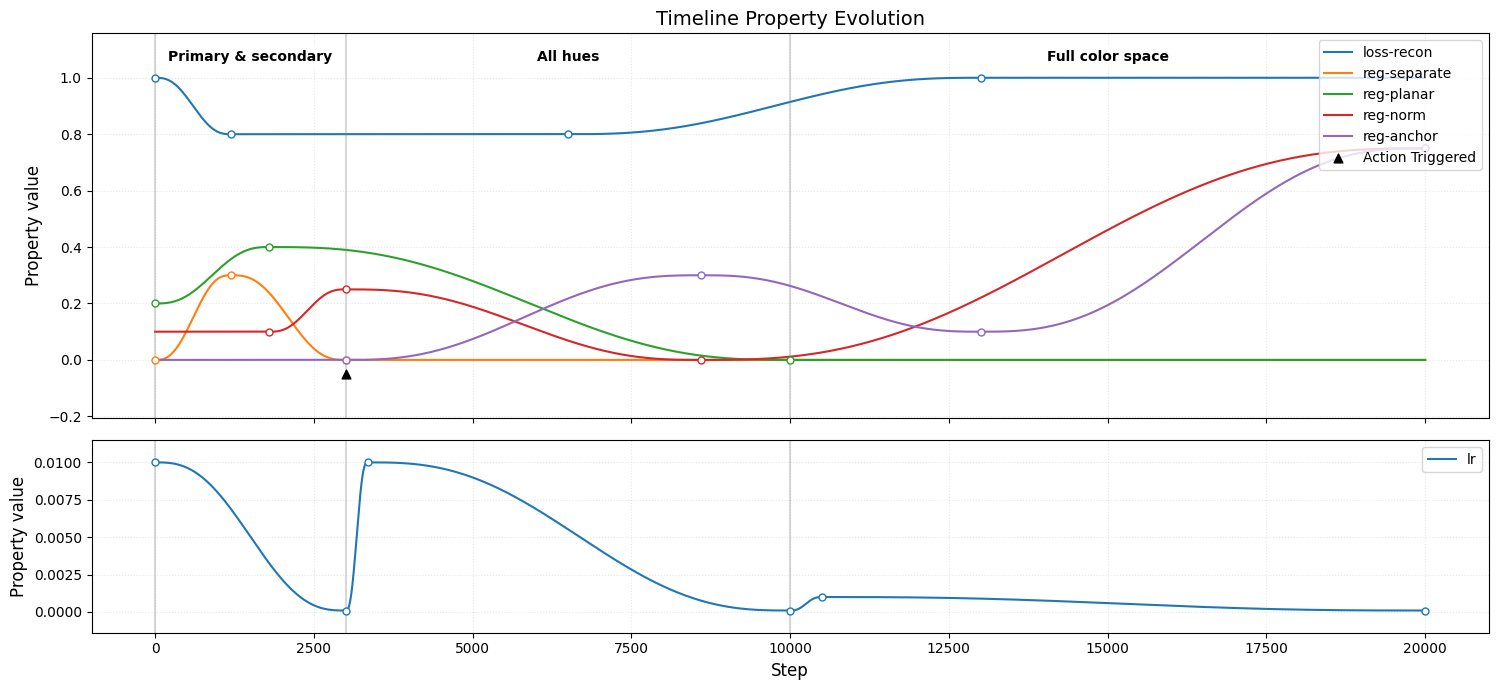

In [11]:
from IPython.display import display, Markdown
from matplotlib import pyplot as plt

from mini.temporal.vis import group_properties_by_scale, plot_timeline, realize_timeline
from mini.temporal.dopesheet import Dopesheet
from mini.temporal.timeline import Timeline

dopesheet = Dopesheet.from_csv('ex-1.5-dopesheet.csv')
display(
    Markdown(f"""
## Parameter schedule
{dopesheet.to_markdown()}
""")
)

timeline = Timeline(dopesheet)
history_df = realize_timeline(timeline)
keyframes_df = dopesheet.as_df()

groups = group_properties_by_scale(keyframes_df[dopesheet.props])
fig, ax = plot_timeline(history_df, keyframes_df, groups)
plt.show(fig)

Training Steps:   0%|          | 0/20001 [00:00<?, ?it/s]

I 355.9 no:    Plotting end of phase: Primary & secondary at step 2999 using provided results.


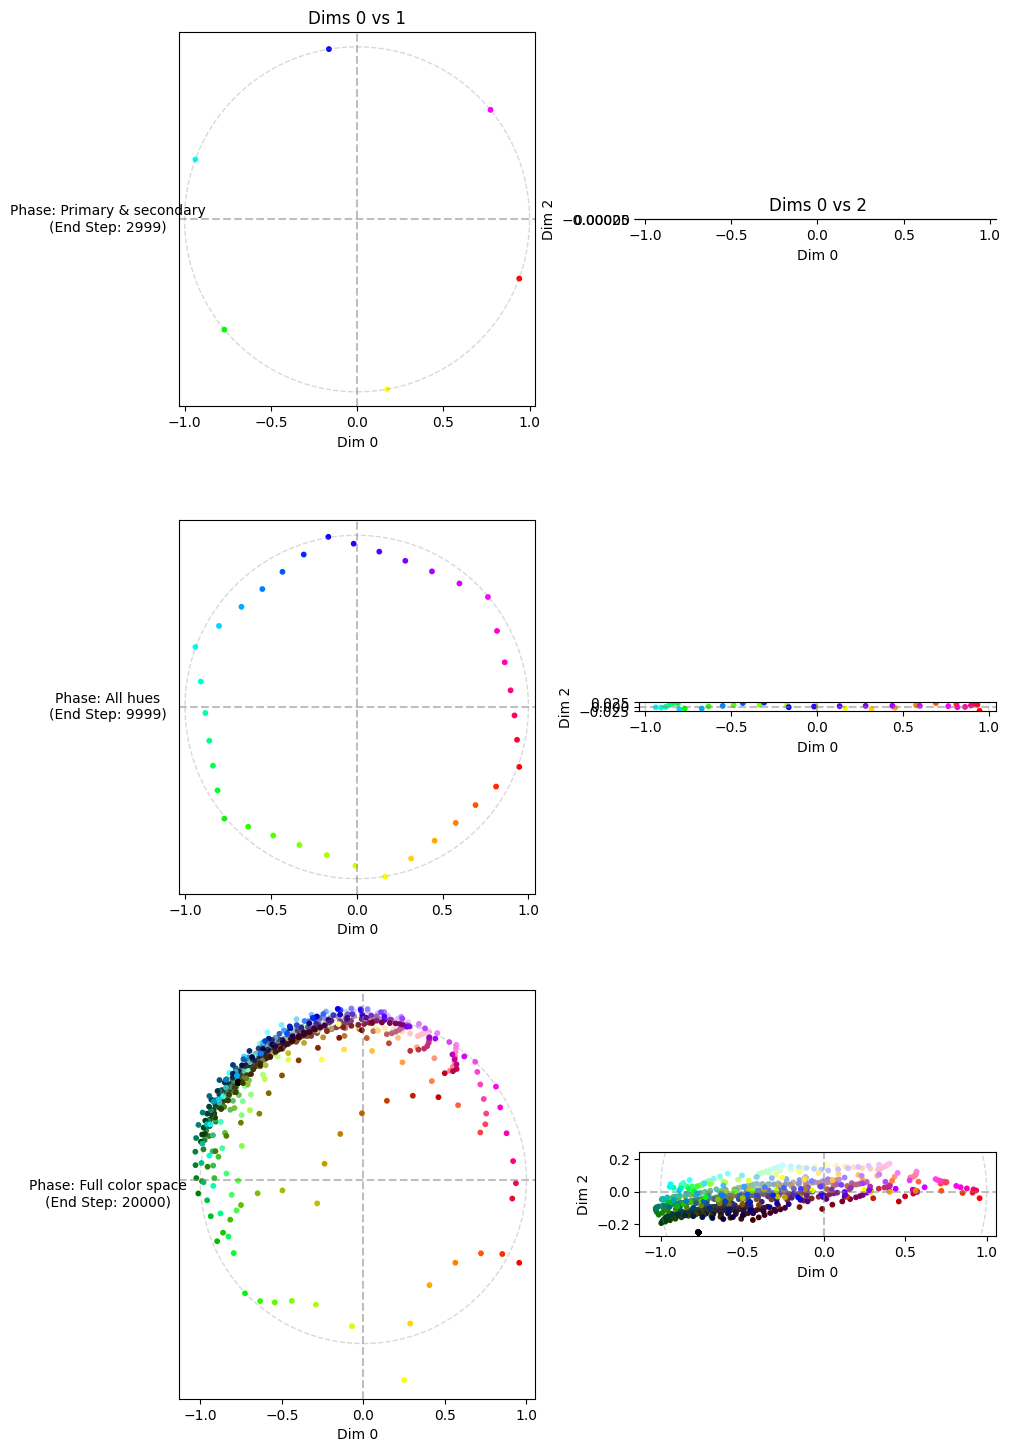

I 356.1 no:    Capturing anchor state via Anchor.on_anchor at step 3000
I 356.1 no:    Anchor state captured internally. Ref data: torch.Size([36, 3]), Ref latents: torch.Size([36, 3])
I 392.9 no:    Plotting end of phase: All hues at step 9999 using provided results.
I 452.4 no:    Plotting end of phase: Full color space at step 20000 using provided results.
I 452.6 no:    Training finished!


In [ ]:
import numpy as np
import torch.nn as nn
from torch import linalg as LA

from ex_color.data.color_cube import ColorCube
from ex_color.data.cyclic import arange_cyclic


def objective(fn):
    """Adapt loss function to look like a regularizer"""

    def wrapper(data: Tensor, res: InferenceResult) -> Tensor:
        return fn(data, res.outputs)

    return wrapper


def unitary(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to have unit norm (vectors of length 1)"""
    norms = LA.vector_norm(res.latents, dim=-1)
    return torch.mean((norms - 1.0) ** 2)


def planarity(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to be planar in the first two channels (so zero in other channels)"""
    return torch.mean(res.latents[:, 2:] ** 2)


class Separate(LossCriterion):
    def __init__(self, channels: tuple[int, ...] = (0, 1)):
        self.channels = channels

    def __call__(self, data: Tensor, res: InferenceResult) -> Tensor:
        """Regularize latents to be separated from each other in first two channels"""
        # Get pairwise differences in the first two dimensions
        points = res.latents[:, self.channels]  # [B, C]
        diffs = points.unsqueeze(1) - points.unsqueeze(0)  # [B, B, C]

        # Calculate squared distances
        sq_dists = torch.sum(diffs**2, dim=-1)  # [B, B]

        # Remove self-distances (diagonal)
        mask = 1.0 - torch.eye(sq_dists.shape[0], device=sq_dists.device)
        masked_sq_dists = sq_dists * mask

        # Encourage separation by minimizing inverse distances (stronger repulsion between close points)
        epsilon = 1e-6  # Prevent division by zero
        return torch.mean(1.0 / (masked_sq_dists + epsilon))


class Anchor(SpecialLossCriterion):
    """Regularize latents to be close to their position in the reference phase"""

    _ref_data: Tensor | None = None
    _ref_latents: Tensor | None = None

    def __init__(self):
        self._ref_data = None
        self._ref_latents = None

    def forward(self, model: ColorMLP, data: Tensor) -> InferenceResult | None:
        """Run the reference dataset through the new model."""
        if self._ref_data is None:
            return None

        device = next(model.parameters()).device
        ref_data = self._ref_data.to(device)

        outputs, latents = model(ref_data)
        return InferenceResult(outputs, latents)

    def __call__(self, data: Tensor, special: InferenceResult) -> Tensor:
        """Calculates loss between current model's latents (for ref_data) and the stored reference latents."""
        if self._ref_latents is None:
            # Should not be possible to get to this point; training loop should check output of `forward`
            raise ValueError('Reference dataset and result must be set before calling.')
        ref_latents = self._ref_latents.to(special.latents.device)
        return torch.mean((special.latents - ref_latents) ** 2)

    def on_anchor(self, event: Event):
        # Called when the 'anchor' event is triggered
        log.info(f'Capturing anchor state via Anchor.on_anchor at step {event.step}')

        device = next(event.model.parameters()).device
        dataset = event.phase_dataset.to(device)

        with torch.no_grad():
            _, latents = event.model(event.phase_dataset)
        self._ref_data = dataset.cpu()
        self._ref_latents = latents.detach().cpu()
        log.info(f'Anchor state captured internally. Ref data: {dataset.shape}, Ref latents: {latents.shape}')


datasets: dict[str, Tensor] = {
    'Primary & secondary': torch.tensor(
        ColorCube.from_hsv(
            h=arange_cyclic(step_size=1 / 6),
            s=np.array([1]),
            v=np.array([1]),
        )
        .permute('svh')
        .rgb_grid.reshape(-1, 3),
        dtype=torch.float32,
    ),
    'All hues': torch.tensor(
        ColorCube.from_hsv(
            h=arange_cyclic(step_size=10 / 360),
            s=np.array([1]),
            v=np.array([1]),
        )
        .permute('svh')
        .rgb_grid.reshape(-1, 3),
        dtype=torch.float32,
    ),
    'Full color space': torch.tensor(
        ColorCube.from_hsv(
            h=arange_cyclic(step_size=10 / 360),
            s=np.linspace(0, 1, 5),
            v=np.linspace(0, 1, 5),
        )
        .permute('svh')
        .rgb_grid.reshape(-1, 3),
        dtype=torch.float32,
    ),
}

model = ColorMLP(normalize_bottleneck=False)

event_handlers = EventHandlers()
plotter = PhasePlotter(dim_pairs=[(0, 1), (0, 2)])
event_handlers.phase_end.add_handler('phase-end', plotter)
reg_anchor = Anchor()
event_handlers.action.add_handler('action:anchor', reg_anchor.on_anchor)

history = train_color_model(
    model,
    datasets,
    dopesheet,
    loss_criteria={
        'loss-recon': objective(nn.MSELoss()),
        'reg-separate': Separate((0, 1)),
        'reg-planar': planarity,
        'reg-norm': unitary,
        'reg-anchor': reg_anchor,
    },
    event_handlers=event_handlers,
)